In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

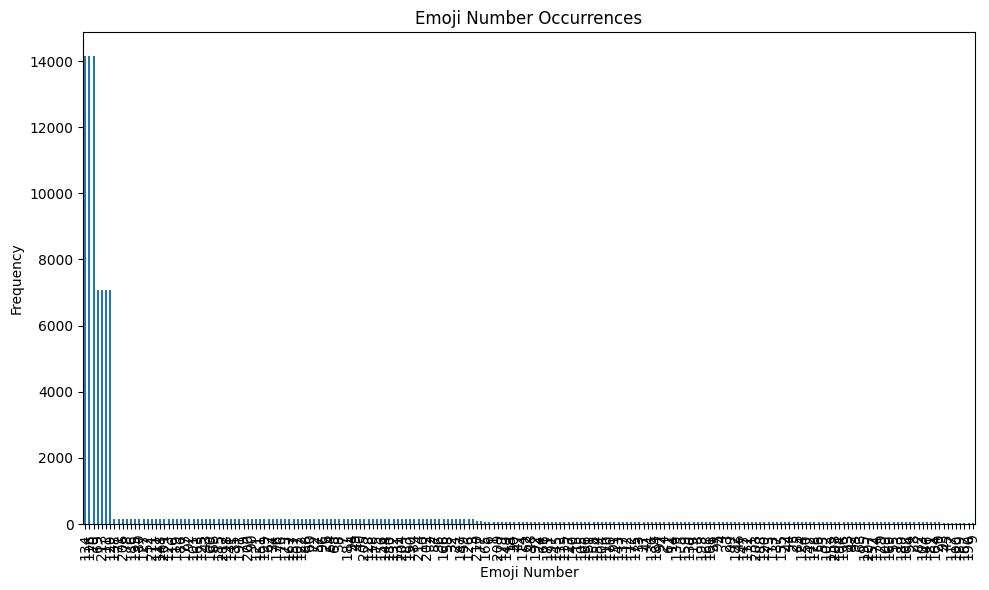

In [14]:
# Load the CSV file
file_path = 'train_emoticon.csv'
df = pd.read_csv(file_path)

# Split the emojis in the input_emoticon column
df['split_emojis'] = df['input_emoticon'].apply(list)

# Create a dictionary to assign each unique emoji a unique number
unique_emojis = sorted(set([emoji for sublist in df['split_emojis'] for emoji in sublist]))
emoji_to_num = {emoji: idx + 1 for idx, emoji in enumerate(unique_emojis)}

# Replace the emojis in each row with their corresponding numbers
df['emoticon_numbers'] = df['split_emojis'].apply(lambda emojis: [emoji_to_num[emoji] for emoji in emojis])

# Flatten the list of numbers to count the occurrences
all_numbers = [num for sublist in df['emoticon_numbers'] for num in sublist]

# Create a pandas Series to count occurrences of each number
emoji_count = pd.Series(all_numbers).value_counts()

# Plot the histogram of occurrences
plt.figure(figsize=(10, 6))
emoji_count.plot(kind='bar')
plt.title('Emoji Number Occurrences')
plt.xlabel('Emoji Number')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [12]:
# Reverse dictionary to map number back to emoji
num_to_emoji = {v: k for k, v in emoji_to_num.items()}

# Get the top 7 most frequent emoji numbers
top_7_numbers = emoji_count.nlargest(7)

# Sum the occurrences of the top 7
sum_top_7 = top_7_numbers.sum()

# Store the corresponding emojis in a set
top_7_emojis = set([num_to_emoji[num] for num in top_7_numbers.index])

# Print the results
print("Sum of occurrences of the top 7 emojis:", sum_top_7)
print("Set of top 7 emojis:", top_7_emojis)



Sum of occurrences of the top 7 emojis: 70800
Set of top 7 emojis: {'🙼', '😣', '😛', '🙯', '😑', '🚼', '🛐'}


Loading training and validation data into dataframe and extracing useful information from it.

In [23]:
top_7_emojis = {'😛', '🛐', '🙯', '😑', '😣', '🚼', '🙼'}  # Replace with actual top 7 emojis

# Load the train_emoticon.csv file
train_file_path = 'train_emoticon.csv'
train_df = pd.read_csv(train_file_path)

# Split the emojis in the input_emoticon column
train_df['split_emojis'] = train_df['input_emoticon'].apply(list)

# Function to remove the top 7 emojis from each row
def remove_top_7_emojis(emojis):
    return [emoji for emoji in emojis if emoji not in top_7_emojis]

# Remove the top 7 emojis from the training dataset
train_df['filtered_emoticons'] = train_df['split_emojis'].apply(remove_top_7_emojis)

# Join the filtered emojis back into a string
train_df['filtered_emoticons_str'] = train_df['filtered_emoticons'].apply(''.join)

# Save the new training dataset to a CSV file without the top 7 emojis
train_df[['filtered_emoticons_str', 'label']].to_csv('train_dataset_without_top7_emojis.csv', index=False)

print("New CSV file 'train_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.")


# Similary for validation data

# Load the top 7 most frequent emojis from the previous analysis
# Ensure that these are the exact emojis you identified
top_7_emojis = {'😛', '🛐', '🙯', '😑', '😣', '🚼', '🙼'}  # Replace with actual top 7 emojis

# Load the valid_emoticon.csv file
valid_file_path = 'valid_emoticon.csv'
valid_df = pd.read_csv(valid_file_path)

# Split the emojis in the input_emoticon column
valid_df['split_emojis'] = valid_df['input_emoticon'].apply(list)

# Function to remove the top 7 emojis from each row
def remove_top_7_emojis(emojis):
    return [emoji for emoji in emojis if emoji not in top_7_emojis]

# Remove the top 7 emojis from the valid dataset
valid_df['filtered_emoticons'] = valid_df['split_emojis'].apply(remove_top_7_emojis)

# Join the filtered emojis back into a string
valid_df['filtered_emoticons_str'] = valid_df['filtered_emoticons'].apply(''.join)

# Save the new valid dataset to a CSV file without the top 7 emojis
valid_df[['filtered_emoticons_str', 'label']].to_csv('valid_dataset_without_top7_emojis.csv', index=False)

print("New CSV file 'valid_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.")

New CSV file 'train_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.
New CSV file 'valid_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.


Applying SGD to the new training data to build the model. Plotting the training and validation data accuracy for the built model.

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

new_training_data = 'train_dataset_without_top7_emojis.csv'
new_validation_data = 'valid_dataset_without_top7_emojis.csv'

# Reading the datasets
train_df = pd.read_csv(new_training_data)
valid_df = pd.read_csv(new_validation_data)

# Spliting the 'filtered_emoticons_str' column into separate columns for each emoji
train_df_split = train_df['filtered_emoticons_str'].apply(lambda x: pd.Series(list(x)))
valid_df_split = valid_df['filtered_emoticons_str'].apply(lambda x: pd.Series(list(x)))

num_emojis = 3  # number of unique emojis in the each training example row
train_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]
valid_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]

# Combining the split columns with the original 'label' column
train_df_final = pd.concat([train_df_split, train_df['label']], axis=1)
valid_df_final = pd.concat([valid_df_split, valid_df['label']], axis=1)

# Showing the first few rows of the training set after splitting
print(train_df_final.head())

# Defining the fractions of the training data to use (from 10% to 100%)
fractions = np.linspace(0.1, 1.0, 10)

# Initializing lists to store accuracies and parameter counts
train_accuracies = []
valid_accuracies = []
parameter_counts = []

# Initializing the OneHotEncoder and fit it on the combined training and validation data
encoder = OneHotEncoder()
combined_data = pd.concat([train_df_final, valid_df_final]).drop(columns=['label'])
encoder.fit(combined_data)

# Defining hyperparameter grid for GridSearchCV
param_grid = {
    'loss': ['modified_huber', 'perceptron', 'hinge', 'log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-2, 1e-1, 1],  # Regularization strengths
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.01, 0.1, 1]  # Initial learning rates
}

# Initializing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(SGDClassifier(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Encoding the full training data
X_train_full_encoded = encoder.transform(train_df_final.drop(columns=['label']))
y_train_full = train_df_final['label']

# Fitting the model on the entire training set to find the best hyperparameters
grid_search.fit(X_train_full_encoded, y_train_full)

# Extracting the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

for fraction in fractions:
    # Subsample the training data
    train_sample = train_df_final.sample(frac=fraction, random_state=42)

    # Separate features and labels for the subsample
    X_train_sample = train_sample.drop(columns=['label'])
    y_train_sample = train_sample['label']

    # Encode the subsampled training data using the pre-fitted encoder
    X_train_encoded = encoder.transform(X_train_sample)

    # Initialize and train the SGDClassifier with the best hyperparameters
    model = SGDClassifier(**best_params, max_iter=1000, tol=1e-3)
    model.fit(X_train_encoded, y_train_sample)

    # Predict on the training set and compute training accuracy
    y_train_pred = model.predict(X_train_encoded)
    train_accuracy = accuracy_score(y_train_sample, y_train_pred)

    # Encode and predict on the validation set
    X_valid_encoded = encoder.transform(valid_df_final.drop(columns=['label']))
    y_valid_pred = model.predict(X_valid_encoded)
    valid_accuracy = accuracy_score(valid_df_final['label'], y_valid_pred)

    # Calculating the number of parameters (features + intercepts)
    num_parameters = model.coef_.shape[1] + model.coef_.shape[0]

    # Storing accuracies and parameter counts
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    parameter_counts.append(num_parameters)

    print(f"Training on {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}, "
          f"Number of Parameters: {num_parameters}")

# Plotting train and validation accuracies against data fractions
plt.figure(figsize=(10, 6))
plt.plot(fractions * 100, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(fractions * 100, valid_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy with Increasing Training Data using SGDClassifier')
plt.legend()
plt.grid(True)
plt.show()


ValueError: Length mismatch: Expected axis has 13 elements, new values have 3 elements